# Extrapolate LCs at early times
See Section 2.1.2 in the paper.

We model the early phase of a SN using models described in Equation (2) and (3) in the paper.

In [1]:
import os
#COCO_PATH=os.environ['COCO_PATH']
COCO_PATH="/Users/ravkaur/Desktop/research/kilonova-SED/PyCoCo_templates/"
DATALC_PATH = COCO_PATH+"/Inputs/Photometry/2_LCs_dust_corrected/"
DATASPEC_PATH = COCO_PATH+"/Inputs/Spectroscopy/"

DATAINFO_PATH= COCO_PATH+"Inputs/SNe_Info/"
FILTER_PATH = COCO_PATH+"Inputs/Filters/"

OUTPUT_PATH = COCO_PATH+"/Inputs/Photometry/3_LCs_early_extrapolated/"

import sys
sys.path.insert(0, COCO_PATH+'what_the_flux/')
import what_the_flux as wtf

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import emcee
import scipy.optimize as opt

import george
from george.kernels import ExpSquaredKernel, ConstantKernel, Matern32Kernel

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_92588/3040087446.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [3]:
info_objects = pd.read_csv(DATAINFO_PATH+'info.dat', comment='#', delimiter=' ')
name_type = dict(zip(info_objects['Name'], info_objects['Type']))

In [4]:
se_sne = [row.Name for i,row in info_objects.iterrows() if row.Type in ['IIb', 'Ib', 'Ic', 'Ic-BL', 'Ibc-pec']]
hydr_sne = [row.Name for i,row in info_objects.iterrows() if row.Type in ['IIn', 'II', 'IIL', 'IIP', '1987A', '87A']]

In [5]:
color_dict = {'Bessell_U': 'blue', 'Bessell_B': 'royalblue','Bessell_V':  'limegreen',
              'Bessell_R':  'red', 'Bessell_I':  'mediumvioletred',
              'sdss_g':'darkgreen','ptf_g':'darkgreen', "sdss_g'":'darkgreen','sdss_i':'indianred',
              "sdss_i'":'indianred','sdss_r': 'darkred', "sdss_r'":'darkred','sdss_z':'sienna', "sdss_z'":'sienna',
              'sdss_u': 'darkblue', "sdss_u'": 'darkblue', 'Y':'salmon','H':'darkred', 'J':  'k',
              'Ks':  'brown','K':  'brown', 'swift_UVW1':'indigo', 'swift_UVW2':'darkblue',
               'swift_UVM2':'darkmagenta','swift_U':'plum','swift_V':'teal','swift_B':'powderblue'}

exclude_filt = ['H', 'J', 'K', 'Ks','KS', 'Y']
#exclude_filt = []

In [6]:

def rise_func(x, a, t0, n):
    f_t = np.zeros(len(x))
    f_t[x>t0] = a * (x[x>t0]-t0)**1.5
    return f_t

In [7]:

class SNPhotometryClass():
    """Class with photometry for each object:
            - load the photometry from the DATA folder
            - get the phootmetry in each filter
            - plot the raw photometry 
            - fit the photometry using GP
    """
    
    def __init__(self, lc_path, snname, verbose=False):
        """
        """

        ## Initialise the class variables
        self.lc_data_path = lc_path+'/'
        self.snname = snname   
        self.set_data_directory(verbose)

    def set_data_directory(self, verbose):
        """
        Set a new data directory path.
        Enables the data directory to be changed by the user.
        """
        SNphotometry_PATH = os.path.join(self.lc_data_path, '%s.dat'%self.snname)
        
        try:
            if verbose: print('Looking for Photometry for %s in%s'%(self.snname, SNphotometry_PATH))
            if os.path.isfile(SNphotometry_PATH):
                if verbose: print ('Got it!')
                self.sn_rawphot_file = SNphotometry_PATH
                pass
            else:
                if not os.path.isdir(self.lc_data_path):
                    print ('I cant find the directory with photometry. Check %s'%self.lc_data_path)
                    pass
                else: 
                    print ('I cant find the file with photometry. Check %s'%SNphotometry_PATH)
                    pass
    
        except Exception as e:
            print (e)

    def load(self, verbose = False):
        """
        Loads a single photometry file.
        with ('MJD', 'Flux', 'Flux_err', 'band')
        
        Parameters
        - verbose
        ----------
        Returns
        - photometry in all filters
        -------
        """
        if verbose: print('Loading %s'%self.sn_rawphot_file)
        try:
            lc_file = np.genfromtxt(self.sn_rawphot_file, dtype=None, encoding="utf-8", 
                                    names=True, delimiter=',')
            mask_filt = np.array([f not in exclude_filt for f in lc_file['band']])
            lc_no_badfilters = lc_file[mask_filt]
            mask_filt = np.array([~np.isnan(f) for f in lc_no_badfilters['Flux']])
            self.phot = lc_no_badfilters[mask_filt]
            
            self.avail_filters = np.unique(self.phot['band'])

            self.phot_extended = self.phot
            print ('Photometry loaded')

        except Exception as e:
            print (e)
            print ('Are you sure you gave me the right format? Check documentation in case.')

    def get_availfilter(self, verbose = False):
        """
        get available filter for this SN
        """
        #if photometry is not already loaded, load it!
        if (not hasattr(self, "phot"))|(not hasattr(self, "avail_filters")):
            self.load()
        return self.avail_filters
        
    def get_singlefilter(self, single_filter, extended_clipped = False, verbose = False):
        """
        Loads from photometry file just 1 filter photometry.
        with ('MJD', 'flux', 'flux_err', 'filter')
        
        Parameters
        - verbose
        ----------
        Returns
        - photometry in all filters
        -------
        """
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()

        if not (isinstance(single_filter, str)):
            print ('Single filter string please')
            return None
        
        if single_filter not in self.avail_filters:
            print ('Looks like the filter you are looking for is not available')
            return None
        
        if extended_clipped:
            if not hasattr(self, "phot_extended"):
                self.extend_photometry()
            filt_index = self.phot_extended['band']==single_filter
            return self.phot_extended[filt_index] 
        else: 
            filt_index = self.phot['band']==single_filter
            return self.phot[filt_index]
        
    
    def get_mjdpeak(self, verbose = False):
        """
        Loads from photometry for each filter, measure peak for each filter
        get a rough estimate of the paek_mjd
        
        Parameters
        - verbose
        ----------
        Returns
        - rough estimate of the peak_mjd
        -------
        """
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()
            
        mjd_peaks_list=[]
        for f in self.avail_filters:
            phot_perfilt = self.get_singlefilter(f)
            mjd_peak = phot_perfilt['MJD'][np.argmax(phot_perfilt['Flux'])]
            mjd_peaks_list.append(mjd_peak)
            
        return np.min(mjd_peaks_list)
    
    def clip_LC_filter(self, filter_name, clipping_mjd_delta = 0.5, pre_bump=False):
        
        def clip_one_point(mjd_unclipped, flux_unclipped, fluxerr_unclipped, filtset_unclipped, instr_unclipped, clipping_index):
            mjd_tbc = np.array([mjd_unclipped[clipping_index], mjd_unclipped[clipping_index+1]])
            flux_tbc = np.array([flux_unclipped[clipping_index], flux_unclipped[clipping_index+1]])
            flux_err_tbc = np.array([fluxerr_unclipped[clipping_index], fluxerr_unclipped[clipping_index+1]])
            mjd_avg = np.average(mjd_tbc)
            flux_avg, sum_w = np.average(flux_tbc, weights= 1./(flux_err_tbc)**2, returned=True)
            flux_err_avg = max([np.std(flux_tbc), np.sqrt(1./sum_w)])
            clipped_mjd_sorted = np.delete(mjd_unclipped, clipping_index)
            clipped_flux_sorted = np.delete(flux_unclipped, clipping_index)
            clipped_flux_err_sorted = np.delete(fluxerr_unclipped, clipping_index)
            clipped_filtset_sorted = np.delete(filtset_unclipped, clipping_index)
            clipped_instr_sorted = np.delete(instr_unclipped, clipping_index)
            clipped_mjd_sorted[clipping_index] = mjd_avg
            clipped_flux_sorted[clipping_index] = flux_avg
            clipped_flux_err_sorted[clipping_index] = flux_err_avg
            #print ('I clipped index:', clipping_index, ' Lenght was %i, now is %i '%(len(mjd_unclipped), len(clipped_mjd_sorted)))
            return clipped_mjd_sorted, clipped_flux_sorted, clipped_flux_err_sorted, clipped_filtset_sorted, clipped_instr_sorted
    
        LC_filt = self.get_singlefilter(filter_name)
        mjd_sorted = np.sort(LC_filt['MJD'])
        flux_sorted = LC_filt['Flux'][np.argsort(LC_filt['MJD'])]
        flux_err_sorted = LC_filt['Flux_err'][np.argsort(LC_filt['MJD'])]
        filtset_sorted = LC_filt['FilterSet'][np.argsort(LC_filt['MJD'])]
        instr_sorted = LC_filt['Instr'][np.argsort(LC_filt['MJD'])]
        
        if pre_bump:
            mask_bump = mjd_sorted>min(mjd_sorted)+10.
            new_mjd_sorted = np.array([round(m,2) for m in mjd_sorted])[mask_bump]
            double = np.where(np.abs(new_mjd_sorted[:-1]-new_mjd_sorted[1:])<clipping_mjd_delta)
            new_flux_sorted = np.copy(flux_sorted)[mask_bump]
            new_flux_err_sorted = np.copy(flux_err_sorted)[mask_bump]
            new_filtset_sorted = np.copy(filtset_sorted)[mask_bump]
            new_Instr_sorted = np.copy(instr_sorted)[mask_bump]
        else:
            new_mjd_sorted = np.array([round(m,2) for m in mjd_sorted])
            double = np.where(np.abs(new_mjd_sorted[:-1]-new_mjd_sorted[1:])<clipping_mjd_delta)
            new_flux_sorted = np.copy(flux_sorted)
            new_flux_err_sorted = np.copy(flux_err_sorted)
            new_filtset_sorted = np.copy(filtset_sorted) 
            new_Instr_sorted = np.copy(instr_sorted) 
            
        while len(np.where(np.abs(new_mjd_sorted[:-1]-new_mjd_sorted[1:])<clipping_mjd_delta)[0])>=1:
            tbc_indexes = np.where(np.abs(new_mjd_sorted[:-1]-new_mjd_sorted[1:])<clipping_mjd_delta)[0]
            ind = tbc_indexes[0]
            R = clip_one_point(new_mjd_sorted, new_flux_sorted, new_flux_err_sorted, new_filtset_sorted, new_Instr_sorted, ind)
            new_mjd_sorted, new_flux_sorted, new_flux_err_sorted, new_filtset_sorted, new_Instr_sorted = R

        if pre_bump:
            new_mjd_sorted = np.concatenate([mjd_sorted[~mask_bump], new_mjd_sorted])
            new_flux_sorted = np.concatenate([flux_sorted[~mask_bump], new_flux_sorted])
            new_flux_err_sorted = np.concatenate([flux_err_sorted[~mask_bump], new_flux_err_sorted])
            new_filtset_sorted = np.concatenate([filtset_sorted[~mask_bump], new_filtset_sorted])       
            new_Instr_sorted = np.concatenate([instr_sorted[~mask_bump], new_Instr_sorted])       

        new_filter_sorted = np.full(len(new_mjd_sorted), filter_name, dtype='|S20')
        new_LC=[]
        for i in zip(new_mjd_sorted, new_filter_sorted, new_flux_sorted, new_flux_err_sorted, new_filtset_sorted, new_Instr_sorted):
            new_LC.append(i)
        new_LC = np.array(new_LC, LC_filt.dtype)
        
        print (filter_name, 'Before clipping %i, after %i'%(len(mjd_sorted), len(new_LC)))
        return new_LC
    
    def clip_photometry(self, pre_bump=False, verbose = False):
        """
        Extend photometry in every filter        
        Parameters
        - verbose
        ----------
        Returns
        - rough estimate of the peak_mjd
        -------
        """
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()
        
        filt_avail = self.avail_filters
        
        clipping_mjd_delta = 1.0
        LC_clipped = np.array([], self.phot.dtype) 
        for ff in filt_avail:
            LC_xfilter = self.clip_LC_filter(ff, clipping_mjd_delta, pre_bump=pre_bump)
            LC_clipped = np.concatenate([LC_clipped, LC_xfilter])
        self.clipped_phot = LC_clipped
        return None
    
    def get_spec_mjd(self, verbose=False):
        phase_list_file = DATASPEC_PATH + '2_spec_lists_smoothed/' + self.snname+'.list'
        try: 
            parse_phase = np.genfromtxt(phase_list_file, dtype=None, encoding="utf-8")
            return parse_phase['f0']
        except: 
            #print ('I looked into %s and I found NO spectra? Ooops'%phase_list_file)
            raise Exception(' WARNING \n I looked into %s and I found NO spectra? Ooops'%phase_list_file)
            return np.array([])
        
    def get_spec_list(self, verbose=False):
        phase_list_file = DATASPEC_PATH + '2_spec_lists_smoothed/' + self.snname+'.list'
        try: 
            parse_phase = np.genfromtxt(phase_list_file, dtype=None,encoding="utf-8")
            return parse_phase['f2']
        except: 
            print ('I looked into %s and I found NO spectra? Ooops'%phase_list_file)
            return np.array([])
    
    def LC_early_extend_xfilter(self, filt, minMJD=None, maxMJD=None):
        LC_filt_extended = self.get_singlefilter(filt, extended_clipped=True)

        mjd_unsorted = LC_filt_extended['MJD']
        mjd = np.sort(mjd_unsorted)
        orig_flux = LC_filt_extended['Flux'][np.argsort(mjd_unsorted)]
        orig_flux_err = LC_filt_extended['Flux_err'][np.argsort(mjd_unsorted)]

        ## norm time
        offset_time = mjd[np.argmax(orig_flux)]
        t = mjd - offset_time
        t_spectra = self.get_spec_mjd() - offset_time
        ## norm flux
        max_fl = max(orig_flux)
        fl = (orig_flux/max_fl)
        flerr = (orig_flux_err/max_fl)

        mask_rising = t<=t[np.argmax(fl)]
        t_rise = t[mask_rising]
        fl_rise = fl[mask_rising]
        flerr_rise = flerr[mask_rising]
        w_rise = 1./flerr_rise**2
        
        fig = plt.figure(figsize=(22,4))
        plt.subplot(141)
        plt.errorbar(t, fl, yerr=flerr, marker='.', 
                     mfc='grey', mec='grey', color='grey', linestyle='None')
        
        plt.errorbar(t_rise, fl_rise, yerr=flerr_rise,marker='.', 
                     mfc='r', mec='r', color='r', linestyle='None')
        plt.title(self.snname+'  '+filt)

        #max_phase = ?
        mjd_last_spec = min(t_spectra)
        mjd_last_phot_point = min(t_rise)
        #end_lc = max(mjd_last_spec, 200)
        end_lc = min( max(mjd_last_phot_point, 200), 250)

        print (filt, mjd_last_phot_point)
        min_phase = -25.
        
        new_t = np.arange(min_phase, min(t)-1.,1.)
        
        plt.subplot(142)
        plt.errorbar(t_rise, fl_rise, yerr=flerr_rise,marker='.', 
                     mfc='k', mec='k', color='k', linestyle='None')
        p0 = [0.8, -20., 2.]

        res = opt.curve_fit(rise_func, phase_prova, flux_prova, p0=p0, 
                    sigma=fluxerr_prova, maxfev=10000) #bounds=([0,-100.,0.], [100., 100., 4.]))

        #plt.plot(t_rise, rise_func(t_rise, p0[0], p0[1]), '--', color="r")

        res = opt.curve_fit(rise_func, t_rise, fl_rise, p0=p0)
        plt.plot(new_t, rise_func(new_t, res[0][0], res[0][1], res[0][2]), '.', color="#4682b4", alpha=1)
        print (p0)
        print (res[0])

        #err_prop_func = lambda x: ( (x*sigma_mm)**2 + sigma_qq**2 )**0.5        
        
        #plt.fill_between(new_t, mm*(new_t)**2+qq - err_prop_func(new_t),
        #                  mm*(new_t)**2+qq + err_prop_func(new_t), color="#4682b4", alpha=0.3)
        
        #plt.plot(new_t, mm_cob56*(new_t)**2+qq, "^g", alpha=0.5)
        #plt.plot(new_t, mm_ni56*(new_t)+qq, "g--", alpha=0.5)
        plt.title(self.snname+'  '+filt)
        #
        fit = max_fl * rise_func(new_t, res[0][0], res[0][1], res[0][2])
        fit_err = np.zeros(len(fit))#max_fl* np.abs(err_prop_func(new_t))
        
        #plt.errorbar(t, orig_flux, yerr=orig_flux_err, marker='.', 
        #             mfc='grey', mec='grey', color='grey', linestyle='None')
        plt.subplot(143)
        plt.errorbar(t_rise, orig_flux[mask_rising], yerr=orig_flux_err[mask_rising], marker='.', 
                     mfc='k', mec='k', color='k', linestyle='None')

        plt.errorbar(new_t, fit, yerr=fit_err, marker='.', 
                     mfc='white', mec='r', color='r', linestyle='None')
        plt.title(self.snname+'  '+filt)
        plt.yscale('log')
        
        plt.subplot(144)
        plt.errorbar(t_rise, orig_flux[mask_rising], yerr=orig_flux_err[mask_rising], marker='.', 
                     mfc='k', mec='k', color='k', linestyle='None')

        plt.errorbar(new_t, fit, yerr=fit_err, marker='.', 
                     mfc='white', mec='r', color='r', linestyle='None')
        plt.title(self.snname+'  '+filt)
        plt.show()
        return (new_t+offset_time, fit, fit_err)

    def create_extended_LC(self, name_file = None):
        lc_file = pd.DataFrame(np.genfromtxt(self.sn_rawphot_file,
                               names=['MJD','band','Flux','Flux_err','FilterSet', 'Source'], 
                               usecols=[0,1,2,3,4,5], 
                               dtype=None,encoding="utf-8"))
        
        for ff in ['Bessell_V']:#np.unique(lc_file['band']):
            print (ff)
            extr_pts_pd = pd.DataFrame().reindex_like(lc_file)[:0]
            
            mjd_new, fit, fit_err = self.LC_early_extend_xfilter(ff)
            extr_pts_pd['MJD'] = mjd_new
            extr_pts_pd['band'] = np.full(len(mjd_new), fill_value=ff)
            extr_pts_pd['Flux'] = fit
            extr_pts_pd['Flux_err'] = fit_err
            extr_pts_pd['FilterSet'] = np.full(len(mjd_new), fill_value='SUDO_PTS')
            extr_pts_pd['Source'] = np.full(len(mjd_new), fill_value='SUDO_PTS')
            #lc_file = lc_file.append(extr_pts_pd)
            lc_file = pd.concat([lc_file, extr_pts_pd], ignore_index=True)
        return lc_file
    

In [8]:
# if you have an exact estimate of the explosion date (t0) from literature specify it here. t0 will be FIXED and not fitted.
# if you have a NON-detection and/or a DISCOVERY date specify these. t0 will be fitted but NON-detection - DISCOVERY date wll be used as bounds.
# Structure of "explosion_dates" dictionary: {SNNAME: (EXPLOSION_DATE, LOWER_LIMIT(i.e. non detection), UPPER_LIMIT(i.e. discovery date))}
explosion_dates = {'iPTF13bvn': (56458.6,None,None),
                  'SN1993J': (None,None,None),
                   'SN2011bm': (None,None,None),
                   'AT2017gfo': (None,None,None)}

# by default power law for SESNe is fixed to n=1.5 and power law for II SNe is fixed to n=0.935 (see Section 2.1.2). 
n_sesn = 1.5
n_hydr = 0.935
# If you want n to be a free parameter add your object to this list
nfree_ = ['iPTF13bvn']
# If you want n to be fixed to a value that is different from the default one specify this here.
sn_n_fix =  {'AT2017gfo': 2.0}

#If your SN has an initial bump and you want to model it, specify it in this dictionary:
# Structure of "pre_bump" dictionary : {SNNAME: [PHASE_BUMP, PEAK_BUMP, b, SIGMA]} --> see equation (3) in the paper
# SN_name, t_bump, b, sigma
pre_bump = {'mySN':[+15.,55712.5,2.0, None]}

# By default V band LCs is always extrapolated at early times (we use only objects with a V-band peak)
# LCs in other OPTICAL filters are extrapolated only if their first data point is within a day from the first V band data point
# Extrapolating UV LCs at early time can be dangerous (especially for Type II, that have a sharp and high peak very early in the LCs)
#     if you want the early extrapolation of UV data you want to explicitly specify it here.
include_dict = {'iPTF13bvn': ['swift_UVW1']}

noBessellV_useswiftV=['SN2008aq', 'SN2011ht', 'SN2006aj', 'SN2013ge']

# If you want to explocitly avoid to do the early extrapolation of the LC in a specific filter(s), specify it here
exclude_dict = {'mySN': ['filter1', 'filter2']}


### FITTING function:
###### t_0 (==t_explosion), n and other parameters will be fixed/fitted according to what you specified earlier

In [9]:

n_hydr_avg=[]
def performe_fit(sn, filt, t_, flux_, fluxerr_, phase_, mjd_Vpeak):

    t0_fix, t0_lower, t0_upper = explosion_dates[sn]
    if t0_lower:
        p_t0 = t0_lower+1.
    else: 
        t0_lower = mjd_Vpeak-100.
        p_t0 = min(min(phase_),-15.)+mjd_Vpeak

    if t0_upper:
        p_t0 = t0_upper-1.
    else: 
        t0_upper = mjd_Vpeak

    if sn in nfree_:
        n_fix = None
        p_n = 1.55
        n_upper = 3.
        n_lower = 0.05
    else:
        n_fix = n_sesn if (sn in se_sne) else n_hydr
        if sn in sn_n_fix: n_fix = sn_n_fix[sn]
        p_n = 1.5 if (sn in se_sne) else 0.3
        n_upper = None
        n_lower = None

    if sn in pre_bump.keys():
        deltaT, t_bump_fix, b_fix, sigma = pre_bump[sn]

        if (isinstance(t_bump_fix, float))&(isinstance(b_fix, float))&(isinstance(sigma, float)):
            names=['a','n']
            def fit(x, a, n):
                t0 = t0_fix
                t_bump = t_bump_fix
                sig = sigma
                b = b_fix
                f_t = np.zeros(len(x))
                f_t[x>t0] = a * (x[x>t0]-t0)**n + b*np.exp(-np.power(x[x>t0] - t_bump, 2.) / (2 * np.power(sig, 2.)))*(1.-np.exp(-(x[x>t0]-t0)))
                return f_t
            p0 = [0.5, 1.5]
            bounds=([0., 0.05],[100., 3.])   

        elif (isinstance(t_bump_fix, float))&(isinstance(b_fix, float))&(~isinstance(sigma, float)):
            names=['a','n','sig']
            def fit(x, a, n, sig):
                t0 = t0_fix
                t_bump = t_bump_fix
                b = b_fix
                f_t = np.zeros(len(x))
                f_t[x>t0] = a * (x[x>t0]-t0)**n + b*np.exp(-np.power(x[x>t0] - t_bump, 2.) / (2 * np.power(sig, 2.)))*(1.-np.exp(-(x[x>t0]-t0)))
                return f_t
            p0 = [0.5, 1.5, 1.]
            bounds=([0., 0.05, 0.05],[100., 3., 10.])   

        elif (isinstance(t_bump_fix, float))&(~isinstance(b_fix, float))&(isinstance(sigma, float)):
            names=['a','n','b']
            def fit(x, a, n, b):
                t0 = t0_fix
                t_bump = t_bump_fix
                sig = sigma
                f_t = np.zeros(len(x))
                f_t[x>t0] = a * (x[x>t0]-t0)**n + b*np.exp(-np.power(x[x>t0] - t_bump, 2.) / (2 * np.power(sig, 2.)))*(1.-np.exp(-(x[x>t0]-t0)))
                return f_t
            p0 = [0.5, 1.5, 0.5]
            bounds=([0., 0.05, 0.],[100., 3., 10000.])   

        elif (isinstance(t_bump_fix, float))&(isinstance(n_fix, float)):
            names=['a','b','sig']
            def fit(x, a, b, sig):
                t0 = t0_fix
                t_bump = t_bump_fix
                n = n_fix
                f_t = np.zeros(len(x))
                f_t[x>t0] = a * (x[x>t0]-t0)**n + b*np.exp(-np.power(x[x>t0] - t_bump, 2.) / (2 * np.power(sig, 2.)))*(1.-np.exp(-(x[x>t0]-t0)))
                return f_t
            p0 = [0.5, 0.5, 1.]
            bounds=([0., 0., 0.05],[100., 10000., 10.])   
        
        elif (isinstance(t_bump_fix, float)):
            names=['a','n','b','sig']
            def fit(x, a, n, b, sig):
                t0 = t0_fix
                t_bump = t_bump_fix
                f_t = np.zeros(len(x))
                f_t[x>t0] = a * (x[x>t0]-t0)**n + b*np.exp(-np.power(x[x>t0] - t_bump, 2.) / (2 * np.power(sig, 2.)))*(1.-np.exp(-(x[x>t0]-t0)))
                return f_t
            p0 = [0.5, 1.5, 0.5, 1.]
            bounds=([0., 0.05, 0., 0.05],[100., 3., 10000., 10.])   

        else:
            names=['a','n','b','t_bump','sig']
            def fit(x, a, n, b, t_bump, sig):
                t0 = t0_fix
                f_t = np.zeros(len(x))
                f_t[x>t0] = a * (x[x>t0]-t0)**n + b*np.exp(-np.power(x[x>t0] - t_bump, 2.) / (2 * np.power(sig, 2.)))*(1.-np.exp(-(x[x>t0]-t0)))
                return f_t        
            p0 = [0.5, 1.5, 0.5, t0_fix+1., 1.]
            bounds=([0., 0.05, 0., t0_fix, 0.05],[100., 3., 10000., t0_fix+5., 10.])     
        
        print ('Fitting', names, 'Initial guess', p0)
        plt.vlines(t0_fix, 0,1, linestyle='-', alpha=0.5)
        #plt.vlines(t_bump, 0,1, linestyle='-',color='r', alpha=0.5)
        
    elif (isinstance(n_fix, float))&(isinstance(t0_fix, float)):
        names=['a']
        def fit(x, a):
            t0 = t0_fix ; n = n_fix
            f_t = np.zeros(len(x)) ; f_t[x>t0] = a * (x[x>t0]-t0)**n
            return f_t
        p0 = [0.5]
        bounds=([0.],[10.])   
        plt.vlines(t0_fix, 0,1, linestyle='-', alpha=0.5)
        print ('Fitting', names, 'Initial guess', p0)

    elif (~isinstance(n_fix, float))&isinstance(t0_fix, float):
        names=['a','n']
        def fit(x, a, n):
            t0 = t0_fix
            f_t = np.zeros(len(x)) ; f_t[x>t0] = a * (x[x>t0]-t0)**n
            return f_t
        p0 = [0.5, p_n]#p_n
        bounds=([0., n_lower],[10.,n_upper])
        plt.vlines(t0_fix, 0,1, linestyle='-', alpha=0.5)
        print ('Fitting', names, 'Initial guess', p0)
    
    elif (isinstance(n_fix, float))&(~isinstance(t0_fix, float)):
        names=['a','t0']
        def fit(x, a, t0):
            n = n_fix
            f_t = np.zeros(len(x)) ; f_t[x>t0] = a * (x[x>t0]-t0)**n
            return f_t
        p0 = [0.5, p_t0]
        bounds=([0., t0_lower],[10.,t0_upper])
        plt.vlines([t0_lower,t0_upper], 0,1, linestyle='--', alpha=0.5)
        print ('Fitting', names, 'Initial guess', p0)

    else:
        names=['a','t0','n']
        def fit(x, a, t0, n):
            f_t = np.zeros(len(x)) ; f_t[x>t0] = a * (x[x>t0]-t0)**n
            return f_t
        p0 = [0.5, p_t0, p_n]
        bounds=([0., t0_lower,n_lower],[10.,t0_upper,n_upper])
        plt.vlines([t0_lower,t0_upper], 0,1, linestyle='--', alpha=0.5)
        print ('Fitting', names, 'Initial guess', p0)

    R,cov = opt.curve_fit(fit, t_, flux_, p0=p0, 
                        sigma=fluxerr_, maxfev=10000, bounds=bounds)
        
    if 't0' in names:
        explos_day = R[np.array(names)=='t0'][0]
    else:
        explos_day = t0_fix
        
    dT = 0.25 if sn not in pre_bump.keys() else 0.1    
    test_times = np.arange(explos_day, 15.+explos_day,10**-4)
    
    FF_pts = np.arange(0.3, min(flux_), 0.05)
    if sn not in hydr_sne: FF_pts = np.arange(0.01, min(flux_), 0.05)
    TT_pts =[]
    for f in FF_pts:
        TT_pts.append(test_times[np.argmin(np.abs(fit(test_times, *R)-f))] )
    t_newpts = np.array(TT_pts)
    if (sn in pre_bump):
        if 't_bump' in names: bump_epoch = R[np.array(names)=='t_bump'][0]# + 2*R[np.array(names)=='sig'][0]
        else: bump_epoch = t_bump_fix
        if 'sig' in names: bump_epoch = bump_epoch+ 3.5*R[np.array(names)=='sig'][0]
        else: bump_epoch = bump_epoch+ 3.5*sigma
        t_newpts = np.arange(explos_day+0.1, bump_epoch,0.01)
    t_extrap = np.arange(min(explos_day-5., -20.+mjd_Vpeak), max(phase_)+mjd_Vpeak,0.1)

    if np.any(np.isinf(cov)): 
        print ('#######################'+'COVARIANCE MATRIX inf')
        fit_ = fit(t_extrap, *R)
        fit_err = 0.1*fit_#np.zeros(len(fit_))

        newpts_ = fit(t_newpts, *R)
        newpts_err = 0.1*newpts_ #np.zeros(len(newpts_))
        success=True
    else:
        rand = np.random.multivariate_normal(R, cov, size=10000)
    
        fit_ = fit(t_extrap, *R)
        fit_err = pd.DataFrame(fit(t_extrap, *par) for par in rand).std().values

        newpts_ = fit(t_newpts, *R)
        newpts_err = pd.DataFrame(fit(t_newpts, *par) for par in rand).std().values
        success=True

    if (sn in hydr_sne)&('n' in names):
        n_hydr_avg.append((R[np.array(names)=='n'][0],filt))

    return R, cov, t_extrap, fit_, fit_err, t_newpts, newpts_, newpts_err, dict(zip(names, np.round(R,1))).items() , success



### Load Photometry and clip it

In [10]:
snname = 'SN2011bm'

In [11]:
SN = SNPhotometryClass(lc_path=DATALC_PATH,snname=snname, verbose=True)
SN.load()
SN.get_availfilter()
SN.clip_photometry(pre_bump= snname in list(pre_bump.keys()))

Looking for Photometry for SN2011bm in/Users/ravkaur/Desktop/research/kilonova-SED/PyCoCo_templates//Inputs/Photometry/2_LCs_dust_corrected//SN2011bm.dat
Got it!
Photometry loaded
Bessell_B Before clipping 43, after 32
Bessell_I Before clipping 45, after 34
Bessell_R Before clipping 45, after 34
Bessell_U Before clipping 27, after 20
Bessell_V Before clipping 45, after 34
sdss_g' Before clipping 22, after 21
sdss_i' Before clipping 22, after 21
sdss_r' Before clipping 22, after 21
sdss_u' Before clipping 17, after 17
sdss_z' Before clipping 21, after 20


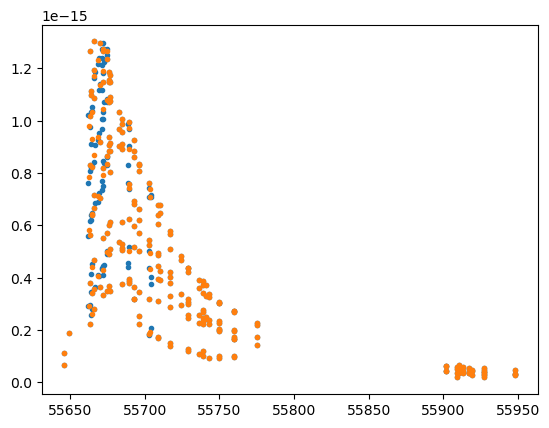

In [12]:
plt.plot(SN.phot['MJD'], SN.phot['Flux'], '.')
plt.plot(SN.clipped_phot['MJD'], SN.clipped_phot['Flux'], '.')

In [13]:
noBessellV_useswiftV=['SN2008aq', 'SN2011ht', 'SN2006aj', 'SN2013ge']

## Performe the fit

V band First data:-14.42 Max point used for fitting:-10.80
Fitting ['a', 't0'] Initial guess [0.5, 55661.94]


/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_62480/1152011066.py:116: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  elif (~isinstance(n_fix, float))&isinstance(t0_fix, float):
/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_62480/1152011066.py:127: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  elif (isinstance(n_fix, float))&(~isinstance(t0_fix, float)):


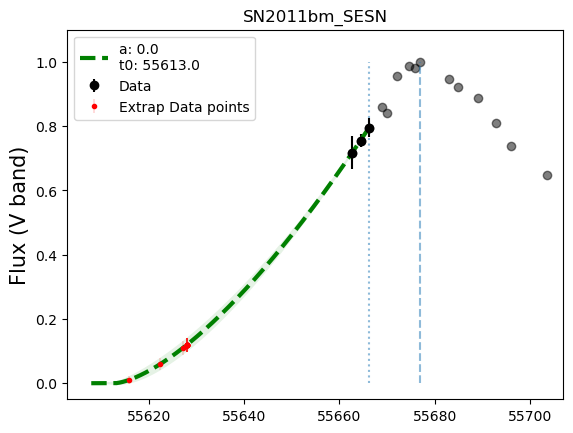

Im extending also ['Bessell_B', 'Bessell_I', 'Bessell_R', 'Bessell_U', "sdss_g'", "sdss_i'", "sdss_r'", "sdss_u'", "sdss_z'"] 

Bessell_B First data:-7.43 Max point used for fitting:-5.52
Fitting ['a', 't0'] Initial guess [0.5, 55654.95]
#######################COVARIANCE MATRIX inf


Bessell_I First data:-20.39 Max point used for fitting:-12.96
Fitting ['a', 't0'] Initial guess [0.5, 55662.524999999994]


/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_62480/1152011066.py:148: OptimizeWarning: Covariance of the parameters could not be estimated
  R,cov = opt.curve_fit(fit, t_, flux_, p0=p0,
/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_62480/1152011066.py:116: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  elif (~isinstance(n_fix, float))&isinstance(t0_fix, float):
/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_62480/1152011066.py:127: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the '



Bessell_R First data:-22.35 Max point used for fitting:-14.92
Fitting ['a', 't0'] Initial guess [0.5, 55662.524999999994]


/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_62480/1152011066.py:116: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  elif (~isinstance(n_fix, float))&isinstance(t0_fix, float):
/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_62480/1152011066.py:127: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  elif (isinstance(n_fix, float))&(~isinstance(t0_fix, float)):




Bessell_U First data:-2.92 Max point used for fitting:0.00
Fitting ['a', 't0'] Initial guess [0.5, 55650.91]


/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_62480/1152011066.py:116: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  elif (~isinstance(n_fix, float))&isinstance(t0_fix, float):
/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_62480/1152011066.py:127: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  elif (isinstance(n_fix, float))&(~isinstance(t0_fix, float)):




sdss_g' First data:-25.82 Max point used for fitting:-10.44
Fitting ['a', 't0'] Initial guess [0.5, 55649.06]


/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_62480/1152011066.py:116: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  elif (~isinstance(n_fix, float))&isinstance(t0_fix, float):
/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_62480/1152011066.py:127: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  elif (isinstance(n_fix, float))&(~isinstance(t0_fix, float)):




sdss_i' First data:-43.07 Max point used for fitting:-23.18
Fitting ['a', 't0'] Initial guess [0.5, 55646.03]


/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_62480/1152011066.py:116: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  elif (~isinstance(n_fix, float))&isinstance(t0_fix, float):
/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_62480/1152011066.py:127: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  elif (isinstance(n_fix, float))&(~isinstance(t0_fix, float)):




sdss_r' First data:-43.07 Max point used for fitting:-23.18
Fitting ['a', 't0'] Initial guess [0.5, 55646.03]


/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_62480/1152011066.py:116: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  elif (~isinstance(n_fix, float))&isinstance(t0_fix, float):
/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_62480/1152011066.py:127: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  elif (isinstance(n_fix, float))&(~isinstance(t0_fix, float)):




sdss_u' First data:-2.92 Max point used for fitting:0.00
Fitting ['a', 't0'] Initial guess [0.5, 55650.92]


/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_62480/1152011066.py:116: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  elif (~isinstance(n_fix, float))&isinstance(t0_fix, float):
/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_62480/1152011066.py:127: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  elif (isinstance(n_fix, float))&(~isinstance(t0_fix, float)):




sdss_z' First data:-26.10 Max point used for fitting:-23.18
Fitting ['a', 't0'] Initial guess [0.5, 55663.0]


/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_62480/1152011066.py:116: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  elif (~isinstance(n_fix, float))&isinstance(t0_fix, float):
/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_62480/1152011066.py:127: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  elif (isinstance(n_fix, float))&(~isinstance(t0_fix, float)):


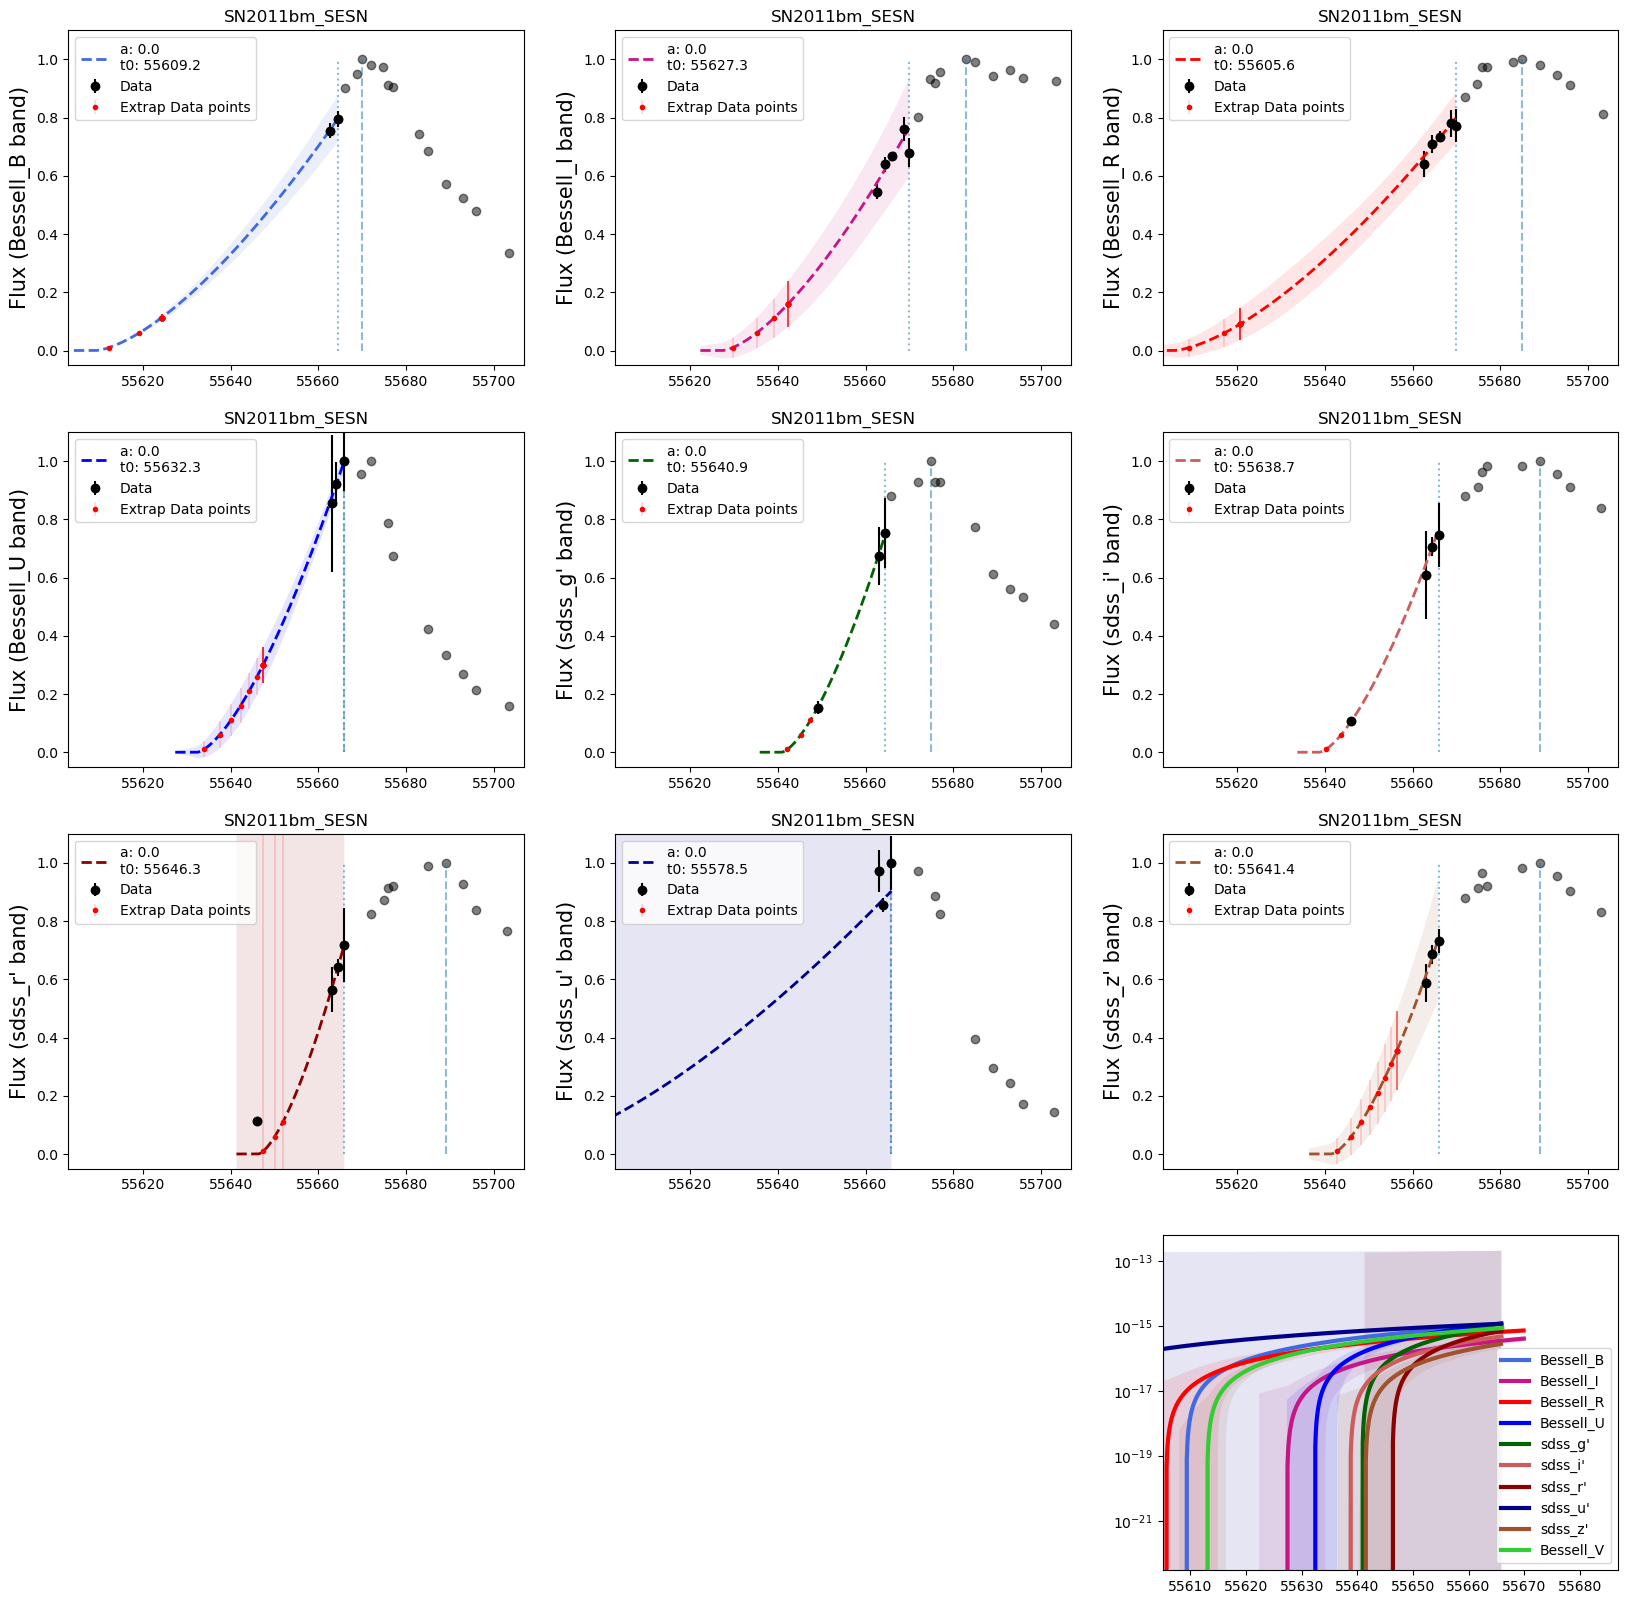

In [17]:
original_phot = pd.DataFrame(SN.phot.copy())
extr_pts_pd = pd.DataFrame(columns=original_phot.columns)#.reindex_like(clipped_phot)[:0]

# Extrapolate BAND V first
band_init = 'Bessell_V' if snname not in noBessellV_useswiftV else 'swift_V'
flux_V = SN.clipped_phot[SN.clipped_phot['band']==band_init]['Flux']
fluxerr_V = SN.clipped_phot[SN.clipped_phot['band']==band_init]['Flux_err']
t_V = SN.clipped_phot[SN.clipped_phot['band']==band_init]['MJD']

mjd_Vpeak = t_V[np.argmax(flux_V)]
Vpeak = max(flux_V)
if snname in pre_bump.keys():
    mjd_Vpeak = explosion_dates[snname][0]+pre_bump[snname][0]
    Vpeak = max(flux_V[t_V>min(t_V)+pre_bump[snname][0]])

plt.plot(t_V, flux_V/Vpeak, 'ok', alpha=0.5)
    
if np.count_nonzero(flux_V[t_V<=mjd_Vpeak]<=0.8*Vpeak)>=2:
    max_MJD = max(t_V[t_V<=mjd_Vpeak][flux_V[t_V<=mjd_Vpeak]<=0.8*Vpeak])
else:
    max_MJD = mjd_Vpeak
print ('V band', 'First data:%.2f'%(min(t_V)-mjd_Vpeak), 'Max point used for fitting:%.2f'%(max_MJD-mjd_Vpeak))

t_ = t_V[t_V<=max_MJD]
phase_ = t_ - mjd_Vpeak
flux_ = flux_V[t_V<=max_MJD]/Vpeak
fluxerr_ = fluxerr_V[t_V<=max_MJD]/Vpeak
plt.vlines(max_MJD, 0,1, linestyle=':', alpha=0.5)

# FIT
R, cov, t_extrapV, fittedV, fittedV_err, t_newpts, newpts_, newpts_err, label_dict, success = performe_fit(snname, band_init, t_, flux_, fluxerr_, phase_, mjd_Vpeak)
    
plt.errorbar(t_, flux_, yerr=fluxerr_, fmt='ok', label='Data')
plt.ylabel('Flux (V band)', fontsize=15)
        
plt.plot(t_extrapV, fittedV, 'g--', lw=3, label='\n'.join("%s: %.1f"%(k,v) for (k,v) in label_dict))
plt.fill_between(t_extrapV, fittedV-fittedV_err, fittedV+fittedV_err,
                 facecolor='g', alpha=0.1)

plt.errorbar(t_newpts, newpts_, yerr=newpts_err, fmt='r.', ecolor='r', elinewidth=0.2, label='Extrap Data points')

plt.xlim(min(min(t_extrapV)-5., -25.+mjd_Vpeak),30.+mjd_Vpeak)
if snname in pre_bump.keys(): plt.xlim((explosion_dates[snname][0]-2.),20.+mjd_Vpeak)
    
if snname in se_sne: plt.title(snname+ '_SESN')
else: plt.title(snname+ ' Type II/IIn')
plt.ylim(-0.05, max(max(fittedV),1.1))
plt.legend()
plt.show()
    
if success:
    extr_pts_pd['MJD'] = t_newpts
    extr_pts_pd['band'] = np.full(len(t_newpts), fill_value=band_init)
    extr_pts_pd['Flux'] = newpts_*Vpeak
    extr_pts_pd['Flux_err'] = newpts_err*Vpeak
    extr_pts_pd['FilterSet'] = np.full(len(t_newpts), fill_value='SUDO_PTS')
    extr_pts_pd['Instr'] = np.full(len(t_newpts), fill_value='SUDO_PTS')
    #original_phot = original_phot.append(extr_pts_pd)
    original_phot = pd.concat([original_phot, extr_pts_pd], ignore_index=True)
else: print ('Something went wrong')
    
i=1
early_bands=[]
exclude_bands = exclude_dict[snname] if snname in exclude_dict else []
include_bands = include_dict[snname] if snname in include_dict else []

for band in np.unique(SN.clipped_phot['band']):
    t_x = SN.clipped_phot[SN.clipped_phot['band']==band]['MJD']
    if (min(t_x)<=min(t_V)+0.5)&(len(t_x[t_x<=max_MJD])>=1):
        if (snname in se_sne)&(band not in [band_init, 'swift_UVW1','swift_UVW2', 'swift_UVM2'])&(band not in exclude_bands):
            early_bands.append(band)
        elif (snname not in se_sne)&(band not in [band_init, 'swift_U', 'Bessell_U', 'swift_UVW1',
                                           'swift_UVW2', 'swift_UVM2'])&(band not in exclude_bands):
            early_bands.append(band)
    if (band in include_bands):
        if band not in early_bands: early_bands.append(band)

N_rows = int(len(early_bands)/3)+1
fig = plt.figure(figsize=(20,N_rows*5))

print ('Im extending also', early_bands, '\n')
for band in early_bands:
    plt.subplot(N_rows,3,i)
    
    flux_x = SN.clipped_phot[SN.clipped_phot['band']==band]['Flux']
    fluxerr_x = SN.clipped_phot[SN.clipped_phot['band']==band]['Flux_err']
    t_x = SN.clipped_phot[SN.clipped_phot['band']==band]['MJD']
    xpeak = max(flux_x)
    mjd_xpeak = t_x[np.argmax(flux_x)]
    if snname in pre_bump.keys():
        mjd_xpeak = explosion_dates[snname][0]+pre_bump[snname][0]
        xpeak = max(flux_x[t_x>mjd_xpeak])
        
    plt.plot(t_x, flux_x/xpeak, 'ok', alpha=0.5)
    
    if np.count_nonzero(flux_x[t_x<=mjd_xpeak]<=0.8*xpeak)>=2:
        max_MJD = max(t_x[t_x<=mjd_xpeak][flux_x[t_x<=mjd_xpeak]<=0.8*xpeak])
    else:
        max_MJD = mjd_xpeak
    print (band, 'First data:%.2f'%(min(t_x)-mjd_xpeak), 'Max point used for fitting:%.2f'%(max_MJD-mjd_xpeak))

    t_ = t_x[t_x<=max_MJD]
    phase_ = t_ - mjd_xpeak
    flux_ = flux_x[t_x<=max_MJD]/xpeak
    fluxerr_ = fluxerr_x[t_x<=max_MJD]/xpeak
    plt.xlim(min(min(t_extrapV)-5., -25.+mjd_Vpeak),30.+mjd_Vpeak)
    if snname in pre_bump.keys(): plt.xlim((explosion_dates[snname][0]-2.),20.+mjd_Vpeak)
    plt.vlines(max_MJD, 0,1, linestyle=':', alpha=0.5)

    results = performe_fit(snname, band, t_, flux_, fluxerr_, phase_, mjd_xpeak)
    R, cov, t_extrap, fitted, fitted_err, t_newpts, newpts_, newpts_err, label_dict, success= results
    
    plt.errorbar(t_, flux_, yerr=fluxerr_, fmt='ok', label='Data')
    
    plt.ylabel('Flux (%s band)'%band, fontsize=15)
    plt.plot(t_extrap, fitted, '--', color=color_dict[band], lw=2,
             label='\n'.join("%s: %.1f"%(k,v) for (k,v) in label_dict))
    plt.fill_between(t_extrap, fitted-fitted_err, fitted+fitted_err,
                 facecolor=color_dict[band], alpha=0.1)
    plt.errorbar(t_newpts, newpts_, yerr=newpts_err, fmt='r.', ecolor='r', elinewidth=0.2, label='Extrap Data points')
    plt.ylim(-0.05, max(max(fitted),1.1))
    
    if snname in se_sne: plt.title(snname+ '_SESN')
    else: plt.title(snname+ ' Type II/IIn')
    plt.legend()
    i=i+1
   
    if success:
        extr_pts_pd = pd.DataFrame(columns=original_phot.columns)#.reindex_like(clipped_phot)[:0]
        extr_pts_pd['MJD'] = t_newpts
        extr_pts_pd['band'] = np.full(len(t_newpts), fill_value=band)
        extr_pts_pd['Flux'] = newpts_ * xpeak
        extr_pts_pd['Flux_err'] = newpts_err * xpeak
        extr_pts_pd['FilterSet'] = np.full(len(t_newpts), fill_value='SUDO_PTS')
        extr_pts_pd['Instr'] = np.full(len(t_newpts), fill_value='SUDO_PTS')
        #original_phot = original_phot.append(extr_pts_pd) 
        original_phot = pd.concat([original_phot, extr_pts_pd], ignore_index=True)
    else: print ('Something went wrong')
    
    plt.subplot(N_rows,3,N_rows*3)
    plt.plot(t_extrap, fitted*xpeak, '-', color=color_dict[band], lw=3, label=band)
    plt.fill_between(t_extrap, (fitted-fitted_err)*xpeak, (fitted+fitted_err)*xpeak,
                         facecolor=color_dict[band], alpha=0.1)
    print ('\n')
plt.subplot(N_rows,3,N_rows*3)
plt.plot(t_extrapV, fittedV*Vpeak, '-', color=color_dict['Bessell_V'], lw=3,
                 label='Bessell_V')
plt.fill_between(t_extrapV, Vpeak*(fittedV-fittedV_err), Vpeak*(fittedV+fittedV_err),
                     facecolor=color_dict[band], alpha=0.1)
plt.xlim(min(min(t_extrapV)-3., -25.+mjd_Vpeak),10.+mjd_Vpeak)

plt.legend()
plt.yscale('log')
plt.show()
plt.close(fig)
    
original_phot.to_csv(OUTPUT_PATH+'/%s.dat'%snname, na_rep='nan',
              index=False, sep='\t')


